# **Aircraft Predictive Maintenance**

# Introduction
a

In [1]:
# Importing libraries

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

# Data Sources
a

In [2]:
# Defining Column Names

id_cols = ['unit', 'cycle'] # Identifiers
op_cols = ['op_setting_1', 'op_setting_2', 'op_setting_3'] # Operating conditions
sensor_cols = [f'sensor_{i}' for i in range(1, 22)] # Sensors 1-21

cols = id_cols + op_cols + sensor_cols

In [3]:
# Defining data file paths

train_path = '../data/raw/cmapss/train_FD001.txt'
test_path = '../data/raw/cmapss/test_FD001.txt'
rul_path = '../data/raw/cmapss/rul_FD001.txt'

## Train Data
a

In [4]:
# Loading the train data

df_train = pd.read_csv(train_path, sep=r'\s+', header=None)

df_train = df_train.iloc[:, :len(cols)]
df_train.columns = cols

df_train

,unit,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [5]:
# Checking df_train data types

df_train.dtypes

unit              int64
cycle             int64
op_setting_1    float64
op_setting_2    float64
op_setting_3    float64
sensor_1        float64
sensor_2        float64
sensor_3        float64
sensor_4        float64
sensor_5        float64
sensor_6        float64
sensor_7        float64
sensor_8        float64
sensor_9        float64
sensor_10       float64
sensor_11       float64
sensor_12       float64
sensor_13       float64
sensor_14       float64
sensor_15       float64
sensor_16       float64
sensor_17         int64
sensor_18         int64
sensor_19       float64
sensor_20       float64
sensor_21       float64
dtype: object

## Test Data
a

In [6]:
# Loading the test data

df_test = pd.read_csv(test_path, sep=r'\s+', header=None)

df_test = df_test.iloc[:, :len(cols)]
df_test.columns = cols

df_test

,unit,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699


In [7]:
# Checking df_test data types

df_test.dtypes

unit              int64
cycle             int64
op_setting_1    float64
op_setting_2    float64
op_setting_3    float64
sensor_1        float64
sensor_2        float64
sensor_3        float64
sensor_4        float64
sensor_5        float64
sensor_6        float64
sensor_7        float64
sensor_8        float64
sensor_9        float64
sensor_10       float64
sensor_11       float64
sensor_12       float64
sensor_13       float64
sensor_14       float64
sensor_15       float64
sensor_16       float64
sensor_17         int64
sensor_18         int64
sensor_19       float64
sensor_20       float64
sensor_21       float64
dtype: object

## RUL Data
a

In [8]:
# Loading the RUL data

df_rul = pd.read_csv(rul_path, header=None, names=['RUL'])

df_rul

,RUL
0,112
1,98
2,69
3,82
4,91
...,...
95,137
96,82
97,59
98,117


In [9]:
# Checking df_rul data types

df_rul.dtypes

RUL    int64
dtype: object

# Data Preprocessing
a

## Standardising Data Types
a

In [10]:
# Defining float and integer columns

int_cols = ['unit', 'cycle']
float_cols = [c for c in df_train.columns if c not in ['unit', 'cycle']]

In [11]:
# Converting identifier columns into integers and everything else into floats

df_train[int_cols] = df_train[int_cols].astype(int)
df_test[int_cols] = df_test[int_cols].astype(int)

df_train[float_cols] = df_train[float_cols].astype(float)
df_test[float_cols] = df_test[float_cols].astype(float)

In [12]:
# Confirming df_train data types

df_train.dtypes

unit              int32
cycle             int32
op_setting_1    float64
op_setting_2    float64
op_setting_3    float64
sensor_1        float64
sensor_2        float64
sensor_3        float64
sensor_4        float64
sensor_5        float64
sensor_6        float64
sensor_7        float64
sensor_8        float64
sensor_9        float64
sensor_10       float64
sensor_11       float64
sensor_12       float64
sensor_13       float64
sensor_14       float64
sensor_15       float64
sensor_16       float64
sensor_17       float64
sensor_18       float64
sensor_19       float64
sensor_20       float64
sensor_21       float64
dtype: object

In [13]:
# Confirming df_test data types

df_test.dtypes

unit              int32
cycle             int32
op_setting_1    float64
op_setting_2    float64
op_setting_3    float64
sensor_1        float64
sensor_2        float64
sensor_3        float64
sensor_4        float64
sensor_5        float64
sensor_6        float64
sensor_7        float64
sensor_8        float64
sensor_9        float64
sensor_10       float64
sensor_11       float64
sensor_12       float64
sensor_13       float64
sensor_14       float64
sensor_15       float64
sensor_16       float64
sensor_17       float64
sensor_18       float64
sensor_19       float64
sensor_20       float64
sensor_21       float64
dtype: object

## Sorting by Engine and Time
a

In [14]:
# Sorting df_train by engine and time

df_train = df_train.sort_values(['unit', 'cycle']).reset_index(drop=True)

df_train

,unit,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392.0,2388.0,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392.0,2388.0,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390.0,2388.0,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392.0,2388.0,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393.0,2388.0,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397.0,2388.0,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395.0,2388.0,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398.0,2388.0,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395.0,2388.0,100.0,38.29,23.0640


In [15]:
# Sorting df_test by engine and time

df_test = df_test.sort_values(['unit', 'cycle']).reset_index(drop=True)

df_test

,unit,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392.0,2388.0,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393.0,2388.0,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393.0,2388.0,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391.0,2388.0,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390.0,2388.0,100.0,38.99,23.4130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,520.69,2388.00,8213.28,8.4715,0.03,394.0,2388.0,100.0,38.65,23.1974
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,521.05,2388.09,8210.85,8.4512,0.03,395.0,2388.0,100.0,38.57,23.2771
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,521.18,2388.04,8217.24,8.4569,0.03,395.0,2388.0,100.0,38.62,23.2051
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,521.33,2388.08,8220.48,8.4711,0.03,395.0,2388.0,100.0,38.66,23.2699


## Duplicate Row Check
a

In [16]:
# Checking for duplicate rows

print(f'df_train Duplicates: {df_train.duplicated(subset=['unit', 'cycle']).sum()}')
print(f'df_test Duplicates: {df_test.duplicated(subset=['unit', 'cycle']).sum()}')

df_train Duplicates: 0
df_test Duplicates: 0


## Missing Value Check
a

In [17]:
# Checking for missing values in df_train

df_train.isna().sum().sort_values(ascending=False).head()

unit         0
cycle        0
sensor_20    0
sensor_19    0
sensor_18    0
dtype: int64

In [18]:
# Checking for missing values in df_test

df_test.isna().sum().sort_values(ascending=False).head()

unit         0
cycle        0
sensor_20    0
sensor_19    0
sensor_18    0
dtype: int64

## Creating the Remaining Useful Life (RUL) Target
a

### RUL for the Train Data
a
$$
RUL = \max(\text{cycle}_{\text{unit}}) - \text{cycle}
$$

In [19]:
# Creating the RUL target for the train data

max_cycle_train = df_train.groupby('unit')['cycle'].max()
df_train['RUL'] = df_train['unit'].map(max_cycle_train) - df_train['cycle']

df_train

,unit,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392.0,2388.0,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392.0,2388.0,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390.0,2388.0,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392.0,2388.0,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393.0,2388.0,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,2388.26,8137.60,8.4956,0.03,397.0,2388.0,100.0,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,2388.22,8136.50,8.5139,0.03,395.0,2388.0,100.0,38.30,23.1594,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,2388.24,8141.05,8.5646,0.03,398.0,2388.0,100.0,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,2388.23,8139.29,8.5389,0.03,395.0,2388.0,100.0,38.29,23.0640,1


### RUL for the Test Data
a
$$
RUL = RUL_{\text{end}} + \left(\max(\text{cycle}_{\text{test, unit}}) - \text{cycle}\right)
$$

In [20]:
# Adding a column for units to df_rul

df_rul['unit'] = df_rul.index + 1

df_rul

,RUL,unit
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5
...,...,...
95,137,96
96,82,97
97,59,98
98,117,99


In [21]:
# Calculating the maximum observed cycle for the test data

max_cycle_test = df_test.groupby('unit')['cycle'].max()

In [22]:
# Merging and creating the RUL target for the test data

df_test = df_test.merge(max_cycle_test.rename('max_cycle'), on='unit', how='left')
df_test = df_test.merge(df_rul, on='unit', how='left')

df_test['RUL'] = df_test['RUL'] + (df_test['max_cycle'] - df_test['cycle'])

df_test.drop(columns=['max_cycle'], inplace=True)

df_test

,unit,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392.0,2388.0,100.0,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393.0,2388.0,100.0,39.02,23.3916,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393.0,2388.0,100.0,39.08,23.4166,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391.0,2388.0,100.0,39.00,23.3737,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390.0,2388.0,100.0,38.99,23.4130,138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,2388.00,8213.28,8.4715,0.03,394.0,2388.0,100.0,38.65,23.1974,24
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,2388.09,8210.85,8.4512,0.03,395.0,2388.0,100.0,38.57,23.2771,23
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,2388.04,8217.24,8.4569,0.03,395.0,2388.0,100.0,38.62,23.2051,22
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,2388.08,8220.48,8.4711,0.03,395.0,2388.0,100.0,38.66,23.2699,21


### Train Data Minimum RUL Check
a

In [23]:
# Checking descriptive statistics of the RUL for the train data

df_train['RUL'].describe()

count    20631.000000
mean       107.807862
std         68.880990
min          0.000000
25%         51.000000
50%        103.000000
75%        155.000000
max        361.000000
Name: RUL, dtype: float64

[min being 0]

### Test Data Minimum RUL Check
a

In [24]:
# Checking the minimum value of the RUL for the test data

df_test.groupby('unit')['RUL'].min()

unit
1      112
2       98
3       69
4       82
5       91
      ... 
96     137
97      82
98      59
99     117
100     20
Name: RUL, Length: 100, dtype: int64

[RUL not being 0]

### Checking the Last Timestep per Unit
a

In [25]:
# Checking the last timestep per unit

df_test.loc[df_test.groupby('unit')['cycle'].idxmax(), ['unit', 'cycle', 'RUL']]

,unit,cycle,RUL
30,1,31,112
79,2,49,98
205,3,126,69
311,4,106,82
409,5,98,91
...,...,...,...
12545,96,97,137
12679,97,134,82
12800,98,121,59
12897,99,97,117


[RUL matching values in df_rul]

### RUL Degradation Visualisation
a

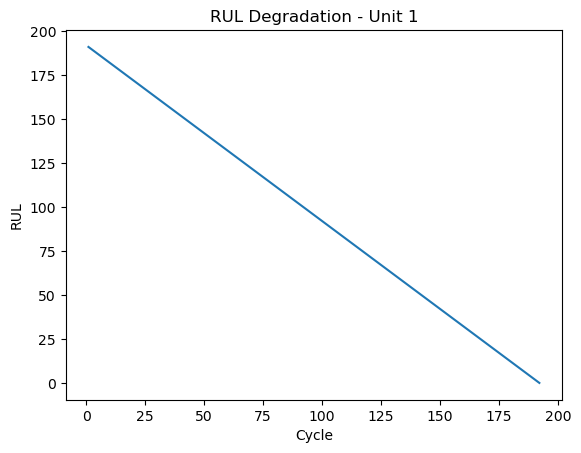

In [26]:
# Visualising RUL degradation

unit_example = 1

subset = df_train[df_train['unit'] == unit_example]

plt.plot(subset['cycle'], subset['RUL'])
plt.xlabel('Cycle')
plt.ylabel('RUL')
plt.title(f'RUL Degradation - Unit {unit_example}')
plt.show()

[straight line going to 0]

## RUL Capping
a

In [27]:
# Capping the RUL

RUL_CAP = 125

df_train['RUL_capped'] = df_train['RUL'].clip(upper=RUL_CAP)
df_test['RUL_capped'] = df_test['RUL'].clip(upper=RUL_CAP)

print(df_train['RUL'].max(), df_train['RUL_capped'].max())
print(df_test['RUL'].max(), df_test['RUL_capped'].max())

361 125
340 125


## Checking for Near-Constant Features
a

In [28]:
# Defining feature columns

feature_cols = [c for c in df_train.columns if c.startswith('op_setting_') or c.startswith('sensor_')]

In [29]:
# Identifying low-variance columns on df_train

variances = df_train[feature_cols].var()
low_var_cols = variances[variances < 1e-8].index.tolist()

print(f'Low-Variance Columns: {low_var_cols}')
print(f'Count: {len(low_var_cols)}')

Low-Variance Columns: ['op_setting_3', 'sensor_1', 'sensor_5', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']
Count: 7


In [30]:
# Dropping low-variance columns from df_train, df_test and feature_cols

df_train = df_train.drop(columns=low_var_cols)
df_test = df_test.drop(columns=low_var_cols)

In [31]:
# Saving the list of low-variance columns for reproducibility

with open('../data/processed/dropped_low_variance_columns.json', 'w') as f:
    json.dump(low_var_cols, f, indent=2)

## Feature Scaling
a

In [32]:
# Re-defining feature columns

feature_cols = [c for c in df_train.columns if c.startswith('op_setting_') or c.startswith('sensor_')]

In [33]:
# Fitting the scaler on df_train

scaler = StandardScaler()

df_train[feature_cols] = scaler.fit_transform(df_train[feature_cols])

df_train

,unit,cycle,op_setting_1,op_setting_2,sensor_2,sensor_3,sensor_4,sensor_6,sensor_7,sensor_8,...,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21,RUL,RUL_capped
0,1,1,-0.315980,-1.372953,-1.721725,-0.134255,-0.925936,0.141683,1.121141,-0.516338,...,-0.266467,0.334262,-1.058890,-0.269071,-0.603816,-0.781710,1.348493,1.194427,191,125
1,1,2,0.872722,-1.031720,-1.061780,0.211528,-0.643726,0.141683,0.431930,-0.798093,...,-0.191583,1.174899,-0.363646,-0.642845,-0.275852,-0.781710,1.016528,1.236922,190,125
2,1,3,-1.961874,1.015677,-0.661813,-0.413166,-0.525953,0.141683,1.008155,-0.234584,...,-1.015303,1.364721,-0.919841,-0.551629,-0.649144,-2.073094,0.739891,0.503423,189,125
3,1,4,0.324090,-0.008022,-0.661813,-1.261314,-0.784831,0.141683,1.222827,0.188048,...,-1.539489,1.961302,-0.224597,-0.520176,-1.971665,-0.781710,0.352598,0.777792,188,125
4,1,5,-0.864611,-0.690488,-0.621816,-1.251528,-0.301518,0.141683,0.714393,-0.516338,...,-0.977861,1.052871,-0.780793,-0.521748,-0.339845,-0.136018,0.463253,1.059552,187,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.178822,-1.031720,1.618000,1.216258,2.188375,0.141683,-2.189329,1.315066,...,1.980044,-2.607969,2.278282,-0.322542,1.425294,2.446751,-1.805173,-2.921113,4,4
20627,100,197,-0.727453,-1.714186,1.717992,2.279706,2.738351,0.141683,-2.833345,1.878576,...,1.867718,-2.350355,1.722087,-0.380207,1.913240,1.155367,-2.856395,-1.203764,3,3
20628,100,198,0.186933,-0.008022,1.478011,1.946971,2.138377,0.141683,-2.742957,2.019453,...,2.054927,-1.902919,2.000184,-0.141684,3.265092,3.092444,-2.081810,-3.292481,2,2
20629,100,199,-0.498857,1.015677,1.098043,2.403666,1.955051,0.141683,-3.036719,2.160330,...,3.178182,-2.363913,1.861136,-0.233948,2.579834,1.155367,-2.911722,-2.085072,1,1


In [34]:
# Applying the scaler to df_test

df_test[feature_cols] = scaler.transform(df_test[feature_cols])

df_test

,unit,cycle,op_setting_1,op_setting_2,sensor_2,sensor_3,sensor_4,sensor_6,sensor_7,sensor_8,...,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21,RUL,RUL_capped
0,1,1,1.055599,1.015677,0.678077,-0.853550,-1.191480,0.141683,0.601408,-0.798093,...,-1.277396,0.415614,-0.919841,-0.954235,-0.985107,-0.781710,0.241943,0.774097,142,125
1,1,2,-1.230366,-1.031720,-1.941707,-0.338137,-1.501467,0.141683,1.674769,-1.220725,...,-0.154141,1.012195,-0.502695,-0.216648,-1.649034,-0.136018,1.127183,0.941305,141,125
2,1,3,0.141213,0.333211,-0.441831,-0.584426,-0.843717,0.141683,0.838677,-0.657216,...,-0.154141,0.754581,-0.919841,-0.715712,0.052112,-0.136018,1.459148,1.172256,140,125
3,1,4,1.924266,-0.008022,-0.481827,-1.044384,-0.279297,0.141683,0.793483,-0.938970,...,-0.977861,-0.045381,-0.641744,-0.568929,-1.345067,-1.427402,1.016528,0.775945,139,125
4,1,5,0.644125,-0.008022,-0.341839,-0.543650,-0.779276,0.141683,0.895170,-1.220725,...,-0.865536,0.998637,-0.919841,-0.745069,-1.041101,-2.073094,0.961200,1.138999,138,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,2.244301,-0.008022,1.118041,1.456023,0.761769,0.141683,0.047780,-1.079848,...,0.557254,-0.980929,-1.336988,3.644806,0.782698,0.509675,-0.919933,-0.852719,24,24
13092,100,195,-0.498857,-0.349255,1.078044,0.842747,1.457295,0.141683,-0.166892,-0.657216,...,0.220277,-0.492817,-0.085548,3.517419,0.241425,1.155367,-1.362553,-0.116449,23,23
13093,100,196,-0.270260,-1.031720,1.518008,0.428459,-0.234855,0.141683,-0.370266,0.188048,...,0.107952,-0.316554,-0.780793,3.852400,0.393408,1.155367,-1.085916,-0.781586,22,22
13094,100,197,-1.733278,0.333211,1.158038,0.728573,1.158419,0.141683,0.002586,-0.375461,...,0.257719,-0.113174,-0.224597,4.022249,0.772033,1.155367,-0.864606,-0.182962,21,21


In [35]:
# Checking the mean of the feature columns in df_train

df_train[feature_cols].mean().head()

op_setting_1    1.377622e-18
op_setting_2   -2.720802e-17
sensor_2        6.410348e-14
sensor_3       -4.959437e-14
sensor_4        9.285169e-16
dtype: float64

[mean being close to 0]

In [36]:
# Checking the standard deviation of the feature columns in df_train

df_train[feature_cols].std().head()

op_setting_1    1.000024
op_setting_2    1.000024
sensor_2        1.000024
sensor_3        1.000024
sensor_4        1.000024
dtype: float64

[std being close to 1]

In [37]:
# Checking the mean of the feature columns in df_test

df_test[feature_cols].std().head()

op_setting_1    1.007052
op_setting_2    1.003329
sensor_2        0.801733
sensor_3        0.816062
sensor_4        0.743114
dtype: float64

[mean not being exactly 0]

In [38]:
# Saving the scaler for reproducibility

joblib.dump(scaler, '../data/processed/standard_scaler.pkl')

['../data/processed/standard_scaler.pkl']

# Feature Engineering
a

In [39]:
# Defining sensor columns

sensor_cols = [c for c in df_train.columns if c.startswith('sensor_')]

## Trend Features
a

In [40]:
# Function to add delta (trend) features

def add_deltas(df, cols):
    df = df.copy()
    df = df.sort_values(['unit', 'cycle'])
    for c in cols:
        df[f'{c}_delta1'] = df.groupby('unit')[c].diff(1)
    
    return df

## Rolling Statistics
a

In [41]:
# Function to add rolling mean/std features

def add_rolling_features(df, cols, windows=(5, 10, 20)):
    df = df.copy()
    df = df.sort_values(['unit', 'cycle'])

    g = df.groupby('unit', group_keys=False)

    for w in windows:
        for c in cols:
            df[f'{c}_rollmean{w}'] = g[c].rolling(window=w).mean().reset_index(level=0, drop=True)
            df[f'{c}_rollstd{w}'] = g[c].rolling(window=w).std().reset_index(level=0, drop=True)
    
    return df

## Applying Feature Engineering
a

In [42]:
# Applying rolling/trend feature engineering to df_train and df_test

windows = (5, 10, 20)

df_train_fe = add_deltas(df_train, sensor_cols)
df_test_fe = add_deltas(df_test, sensor_cols)

df_train_fe = add_rolling_features(df_train_fe, sensor_cols, windows)
df_train_fe = add_rolling_features(df_test_fe, sensor_cols, windows)

In [43]:
# Handling missing values created by new features

min_w = max(windows)

df_train_fe = df_train_fe.groupby('unit').apply(lambda x: x.iloc[min_w-1:]).reset_index(drop=True)
df_test_fe = df_test_fe.groupby('unit').apply(lambda x: x.iloc[min_w-1:]).reset_index(drop=True)

C:\Users\Nitro\AppData\Local\Temp\ipykernel_34072\2532868375.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train_fe = df_train_fe.groupby('unit').apply(lambda x: x.iloc[min_w-1:]).reset_index(drop=True)
C:\Users\Nitro\AppData\Local\Temp\ipykernel_34072\2532868375.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_test_fe = df_test_fe.groupby('unit').apply(lambda x: x.iloc[min_w-1:]).reset_index

In [44]:
# Checking train data shapes

print(f'Train Data Shape Before: {df_train.shape}')
print(f'Train Data Shape After: {df_train_fe.shape}')

Train Data Shape Before: (20631, 21)
Train Data Shape After: (11196, 126)


In [45]:
# Checking missing values for train and test data

print(f'Train Data NaNs: {df_train_fe.isna().sum().sum()}')
print(f'Test Data NaNs: {df_test_fe.isna().sum().sum()}')

Train Data NaNs: 0
Test Data NaNs: 0


[NaNs being 0]

# Train/Validation Split
a

In [46]:
# Defining the split ratio

VAL_RATIO = 0.2
RANDOM_STATE = 42

In [47]:
# Obtaining unique engine IDs from train data

units = df_train_fe['unit'].unique()
n_units = len(units)

n_val = int(n_units * VAL_RATIO)

In [48]:
# Choosing the validation engine randomly

rng = np.random.default_rng(RANDOM_STATE)
val_units = rng.choice(units, size=n_val, replace=False)

In [49]:
# Splitting the data

df_val = df_train_fe[df_train_fe['unit'].isin(val_units)].reset_index(drop=True)
df_trn = df_train_fe[~df_train_fe['unit'].isin(val_units)].reset_index(drop=True)

## Checks
a

In [50]:
# Checking for no engine overlap

set(df_trn['unit']).intersection(set(df_val['unit']))

set()

[no engine overlap]

In [51]:
# Checking the distribution of train and validate data

print(f'Train Data Units: {df_trn['unit'].nunique()}')
print(f'Validate Data Units: {df_val['unit'].nunique()}')

Train Data Units: 80
Validate Data Units: 20


[80/20 split]

In [52]:
# Checking the RUL ranges for the train data

df_trn['RUL'].describe()

count    9071.000000
mean      131.932973
std        56.261064
min         7.000000
25%        95.000000
50%       131.000000
75%       167.000000
max       321.000000
Name: RUL, dtype: float64

In [53]:
# Checking the RUL ranges for the validate data

df_val['RUL'].describe()

count    2125.000000
mean      131.568471
std        54.702626
min        10.000000
25%        93.000000
50%       130.000000
75%       167.000000
max       270.000000
Name: RUL, dtype: float64

[train and validate data being comparable]

In [54]:
# Separating features and targets

TARGET = 'RUL_capped'

X_train = df_trn.drop(columns=['unit', 'cycle', 'RUL', 'RUL_capped'])
y_train = df_trn[TARGET]

X_val = df_val.drop(columns=['unit', 'cycle', 'RUL', 'RUL_capped'])
y_val = df_val[TARGET]

In [55]:
# Checking the shape of train and validate features

X_train.shape, X_val.shape

((9071, 122), (2125, 122))

# Baseline Model
a

## Model Training and Evaluation
a

In [56]:
# Training and evaluating the baseline model

ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train, y_train)

pred_val = ridge.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, pred_val))
mae = mean_absolute_error(y_val, pred_val)
r2 = r2_score(y_val, pred_val)

print(f'Target: {TARGET}')
print(f'RMSE: {rmse:.3f}')
print(f'MAE: {mae:.3f}')
print(f'R^2: {r2:.3f}')

Target: RUL_capped
RMSE: 17.476
MAE: 13.942
R^2: 0.611


[interpretation]

## Model Plot
a

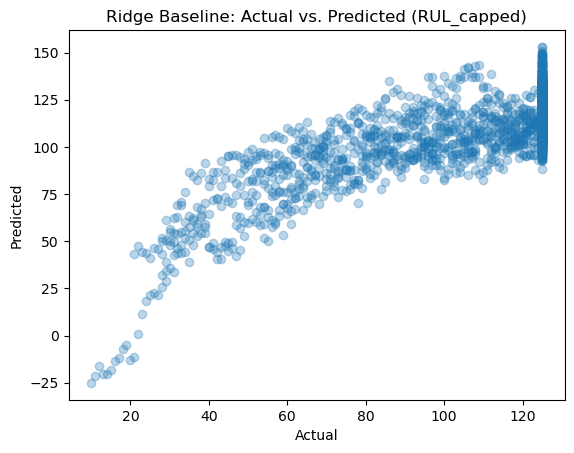

In [57]:
# Plotting actual vs. predicted capped RUL

plt.scatter(y_val, pred_val, alpha=0.3)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Ridge Baseline: Actual vs. Predicted ({TARGET})')
plt.show()

[interpretation]

## Per-Engine Evaluation at Final Cycle
a

In [58]:
# Evaluating per-engine at the final cycle

df_val_eval = df_val.copy()
df_val_eval['pred'] = pred_val

last_rows = df_val_eval.loc[df_val_eval.groupby('unit')['cycle'].idxmax()]

rmse_last = np.sqrt(mean_squared_error(last_rows[TARGET], last_rows['pred']))
mae_last = mean_absolute_error(last_rows[TARGET], last_rows['pred'])

print(f'Final-Cycle RMSE: {rmse_last:.3f}')
print(f'Final-Cycle MAE: {mae_last:.3f}')

Final-Cycle RMSE: 17.287
Final-Cycle MAE: 14.206


# XGBoost Regression for RUL
a

# Building DMatrix
a

In [59]:
# Building DMatrix

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

## Defining Hyperparameters
a

In [60]:
# Defining hyperparameters

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 6,
    'eta': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

## Training the Model with Early Stopping
a

In [61]:
# Training the model with early stopping

evals = [(dtrain, 'train'), (dval, 'val')]

xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=100
)

[0]	train-rmse:28.13463	val-rmse:27.36914
[100]	train-rmse:7.70046	val-rmse:19.30056
[200]	train-rmse:4.81203	val-rmse:19.19022
[300]	train-rmse:3.35234	val-rmse:19.13813
[337]	train-rmse:2.96696	val-rmse:19.15478


## Model Evaluation on the Validation Data
a

In [62]:
# Evaluating the model on the validation data

pred_val = xgb_model.predict(dval)

rmse = np.sqrt(mean_squared_error(y_val, pred_val))
mae = mean_absolute_error(y_val, pred_val)
r2 = r2_score(y_val, pred_val)

print(f'XGBoost ({TARGET})')
print(f'RMSE: {rmse:.3f}')
print(f'MAE: {mae:.3f}')
print(f'R^2: {r2:.3f}')

XGBoost (RUL_capped)
RMSE: 19.155
MAE: 13.217
R^2: 0.532


## Final-Cycle Evaluation
a

In [64]:
# Evaluating at the final-cycle

df_val_eval = df_val.copy()
df_val_eval['pred'] = pred_val

last_rows = df_val_eval.loc[df_val_eval.groupby('unit')['cycle'].idxmax()]

rmse_last = np.sqrt(mean_squared_error(last_rows[TARGET], last_rows['pred']))
mae_last = mean_absolute_error(last_rows[TARGET], last_rows['pred'])

print(f'Final-Cycle RMSE: {rmse_last:.3f}')
print(f'Final-Cycle MAE: {mae_last:.3f}')

Final-Cycle RMSE: 18.078
Final-Cycle MAE: 14.198


[interpretation of differences with ridge]

## Saving the Model
a

In [66]:
# Saving the model

joblib.dump(xgb_model, '../models/xgboost_fd001.pkl')

['../models/xgboost_fd001.pkl']